# Test Delight template fitting

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 3rd 2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [3]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [4]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [5]:
FLAG_DC2=False

In [6]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
else:
    configfilename='tmpsim/parametersTest.cfg'

# Load config and data

In [7]:
comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

if threadNum == 0:
    logger.info("--- TEMPLATE FITTING ---")

2021-04-03 18:45:09,831 ipykernel_launcher.py, __main__[388] INFO --- TEMPLATE FITTING ---


In [8]:
# Parse parameters file

paramFileName = configfilename
params = parseParamFile(paramFileName, verbose=False)

if threadNum == 0:
    msg = 'Thread number / number of threads: ' + str(threadNum+1) + " , " + str(numThreads)
    logger.info(msg)
    msg = 'Input parameter file:' + paramFileName
    logger.info(msg)

2021-04-03 18:45:09,862 ipykernel_launcher.py, __main__[388] INFO Thread number / number of threads: 1 , 1
2021-04-03 18:45:09,863 ipykernel_launcher.py, __main__[388] INFO Input parameter file:tmpsim/parametersTest.cfg


In [9]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
numZ = redshiftGrid.size

# Locate which columns of the catalog correspond to which bands.

bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="target_")

dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']

# f_mod  : flux model in each band as a function of the sed and the band name
# axis 0 : redshifts
# axis 1 : sed names
# axis 2 : band names

f_mod = np.zeros((redshiftGrid.size, len(sed_names),len(params['bandNames'])))

# loop on SED to load the flux-redshift file from the training
# ture data or simulated by simulateWithSEDs.py

for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))

firstLine = int(threadNum * numObjectsTarget / float(numThreads))
lastLine = int(min(numObjectsTarget,(threadNum + 1) * numObjectsTarget / float(numThreads)))
numLines = lastLine - firstLine

if threadNum == 0:
    msg='Number of Target Objects ' + str(numObjectsTarget)
    logger.info(msg)

comm.Barrier()

msg= 'Thread ' + str(threadNum) + ' , analyzes lines ' + str(firstLine) +  ' , to ' +  str(lastLine)
logger.info(msg)

numMetrics = 7 + len(params['confidenceLevels'])


<ipython-input-9-4e86fa1831e5>:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))
2021-04-03 18:45:09,937 ipykernel_launcher.py, __main__[388] INFO Number of Target Objects 1000
2021-04-03 18:45:09,939 ipykernel_launcher.py, __main__[388] INFO Thread 0 , analyzes lines 0 , to 1000


In [10]:
# Create local files to store results
localPDFs = np.zeros((numLines, numZ))
localMetrics = np.zeros((numLines, numMetrics))

all_ell = []


# Now loop over each target galaxy (indexed bu loc index) to compute likelihood function
# with its flux in each bands
loc = - 1
trainingDataIter = getDataFromFile(params, firstLine, lastLine,prefix="target_", getXY=False)
for z, normedRefFlux, bands, fluxes, fluxesVar,bCV, fCV, fvCV in trainingDataIter:
    loc += 1
    # like_grid, _ = scalefree_flux_likelihood(
    #    fluxes, fluxesVar,
    #    f_mod[:, :, bands])
    # ell_hat_z = normedRefFlux * 4 * np.pi\
    #    * params['fluxLuminosityNorm'] \
    #    * (DL(redshiftGrid)**2. * (1+redshiftGrid))[:, None]
    ell_hat_z = 1
    params['ellPriorSigma'] = 1e12

    # approximate flux likelihood, with scaling of both the mean and variance.
    # This approximates the true likelihood with an iterative scheme.
    # - data : fluxes, fluxesVar
    # - model based on SED : f_mod
    like_grid = approx_flux_likelihood(fluxes, fluxesVar, f_mod[:, :, bands],\
                                       normalized=True,\
                                       marginalizeEll=True,\
                                       ell_hat=ell_hat_z,\
                                       ell_var=(ell_hat_z*params['ellPriorSigma'])**2)
    
    ell = approx_flux_likelihood(fluxes, fluxesVar, f_mod[:, :, bands],\
                                       normalized=True,\
                                       marginalizeEll=True,\
                                       ell_hat=ell_hat_z,\
                                       ell_var=(ell_hat_z*params['ellPriorSigma'])**2,returnEllML=True)
    
    all_ell.append(ell)

    b_in = np.array(params['p_t'])[None, :]
    beta2 = np.array(params['p_z_t'])**2.0

    #compute prior on z

    p_z = b_in * redshiftGrid[:, None] / beta2[None, :] *np.exp(-0.5 * redshiftGrid[:, None]**2 / beta2[None, :])
    like_grid *= p_z

    localPDFs[loc, :] += like_grid.sum(axis=1)
    
    if localPDFs[loc, :].sum() > 0:
        localMetrics[loc, :] = computeMetrics(z, redshiftGrid,localPDFs[loc, :],params['confidenceLevels'])



In [12]:
all_ell=np.array(all_ell)

In [13]:
all_ell.shape

(1000, 300, 8, 1)

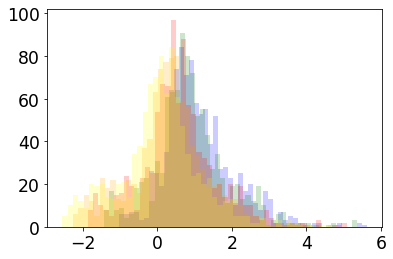

In [29]:
plt.hist(np.log10(all_ell[:,200,0,:]),bins=50,facecolor="b",alpha=0.2);
plt.hist(np.log10(all_ell[:,200,1,:]),bins=50,facecolor="g",alpha=0.2);
plt.hist(np.log10(all_ell[:,200,2,:]),bins=50,facecolor="r",alpha=0.2);
plt.hist(np.log10(all_ell[:,200,3,:]),bins=50,facecolor="orange",alpha=0.2);
plt.hist(np.log10(all_ell[:,200,4,:]),bins=50,facecolor="yellow",alpha=0.2);

In [ ]:
alert False

In [ ]:
#plt.hist(np.log10(np.array(all_ell)),bins=100);
#plt.xlabel("$log_{10}(\ell)$")
#plt.title("distribution of fitted $\ell$")

In [14]:
comm.Barrier()
if threadNum == 0:
    globalPDFs = np.zeros((numObjectsTarget, numZ))
    globalMetrics = np.zeros((numObjectsTarget, numMetrics))
else:
    globalPDFs = None
    globalMetrics = None

firstLines = [int(k*numObjectsTarget/numThreads) for k in range(numThreads)]
lastLines = [int(min(numObjectsTarget, (k+1)*numObjectsTarget/numThreads)) for k in range(numThreads)]
numLines = [lastLines[k] - firstLines[k] for k in range(numThreads)]

sendcounts = tuple([numLines[k] * numZ for k in range(numThreads)])
displacements = tuple([firstLines[k] * numZ for k in range(numThreads)])
comm.Gatherv(localPDFs,[globalPDFs, sendcounts, displacements, MPI.DOUBLE])

sendcounts = tuple([numLines[k] * numMetrics for k in range(numThreads)])
displacements = tuple([firstLines[k] * numMetrics for k in range(numThreads)])
comm.Gatherv(localMetrics,[globalMetrics, sendcounts, displacements, MPI.DOUBLE])

comm.Barrier()

if threadNum == 0:
    fmt = '%.2e'
    np.savetxt(params['redshiftpdfFileTemp'], globalPDFs, fmt=fmt)
    if redshiftColumn >= 0:
        np.savetxt(params['metricsFileTemp'], globalMetrics, fmt=fmt)